## Exploratory Data Analysis

### Understanding the Problem

Using bank data, predict whether a customer will subscribe to a bank term deposit. The real-world goal of such a project would not just be to find the model with the highest prediction ROC AUC score but also to identify the factors which most often correlate to the desired outcome (or vice versa).  This would in turn provide the bank with a better understanding of which customers to target with promotions and enticements to come in and explore the possibility of setting up a bank term deposit. 


### Expected Output

Binary classification, 1 (TRUE) for customers who are predicted to open a bank term deposit and 0 (FALSE) for customers who are predicted to not open a bank term deposit.

In [25]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Download Data if it hasn't already been downloaded
if not os.path.exists("../data/train.csv"):
    # If path doesn't exist, attempt to install Kaggle CLI
    !pip install -q kaggle

    # Then, download data and unzip it from playground dataset
    !kaggle competitions download -c playground-series-s5e8 -p ../data/
    !unzip ../data/playground-series-s5e8.zip -d ../data/

In [7]:
# Read in & inspect data
bank_data = pd.read_csv("../data/train.csv")
bank_data.head()

,id,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,0,42,technician,married,secondary,no,7,no,no,cellular,25,aug,117,3,-1,0,unknown,0
1,1,38,blue-collar,married,secondary,no,514,no,no,unknown,18,jun,185,1,-1,0,unknown,0
2,2,36,blue-collar,married,secondary,no,602,yes,no,unknown,14,may,111,2,-1,0,unknown,0
3,3,27,student,single,secondary,no,34,yes,no,unknown,28,may,10,2,-1,0,unknown,0
4,4,26,technician,married,secondary,no,889,yes,no,cellular,3,feb,902,1,-1,0,unknown,1


In [8]:
# Check dataset shape & data types
bank_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 750000 entries, 0 to 749999
Data columns (total 18 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   id         750000 non-null  int64 
 1   age        750000 non-null  int64 
 2   job        750000 non-null  object
 3   marital    750000 non-null  object
 4   education  750000 non-null  object
 5   default    750000 non-null  object
 6   balance    750000 non-null  int64 
 7   housing    750000 non-null  object
 8   loan       750000 non-null  object
 9   contact    750000 non-null  object
 10  day        750000 non-null  int64 
 11  month      750000 non-null  object
 12  duration   750000 non-null  int64 
 13  campaign   750000 non-null  int64 
 14  pdays      750000 non-null  int64 
 15  previous   750000 non-null  int64 
 16  poutcome   750000 non-null  object
 17  y          750000 non-null  int64 
dtypes: int64(9), object(9)
memory usage: 103.0+ MB


The data was synthetically generated (as per the contest overview), thus no null values are present in the dataset.  Will revisit this later when we incorporate (or at least inspect) the original bank dataset from which this dataset was constructed.

However, further inspection revealed the presence of "unknown" values in the dataset:

In [20]:
# Look for "unknowns" in the dataset
for col in cat_feats:
    print(f"{col}: {(bank_data[col] == 'unknown').sum()} unknowns")

job: 2917 unknowns
marital: 0 unknowns
education: 21299 unknowns
default: 0 unknowns
housing: 0 unknowns
loan: 0 unknowns
contact: 231627 unknowns
month: 0 unknowns
poutcome: 672450 unknowns


We'll have to address those unknowns; for now, we'll continue exploration.

Next, separate features for further analysis based on data type (categorical vs. numerical):

In [21]:
cat_feats = bank_data.select_dtypes('object').columns.to_list()
num_feats = bank_data.select_dtypes(include='int64').columns.to_list()

# Remove target variable from analysis; will analyze separately
num_feats = [x for x in num_feats if x != 'y']

In [22]:
# Determine distribution of label/target column; confirm they're binary values
bank_data.y.value_counts()

y
0    659512
1     90488
Name: count, dtype: int64

## Investigate Variables

Checking for outliers, unknowns, and features with low variance.

### Categorical Features

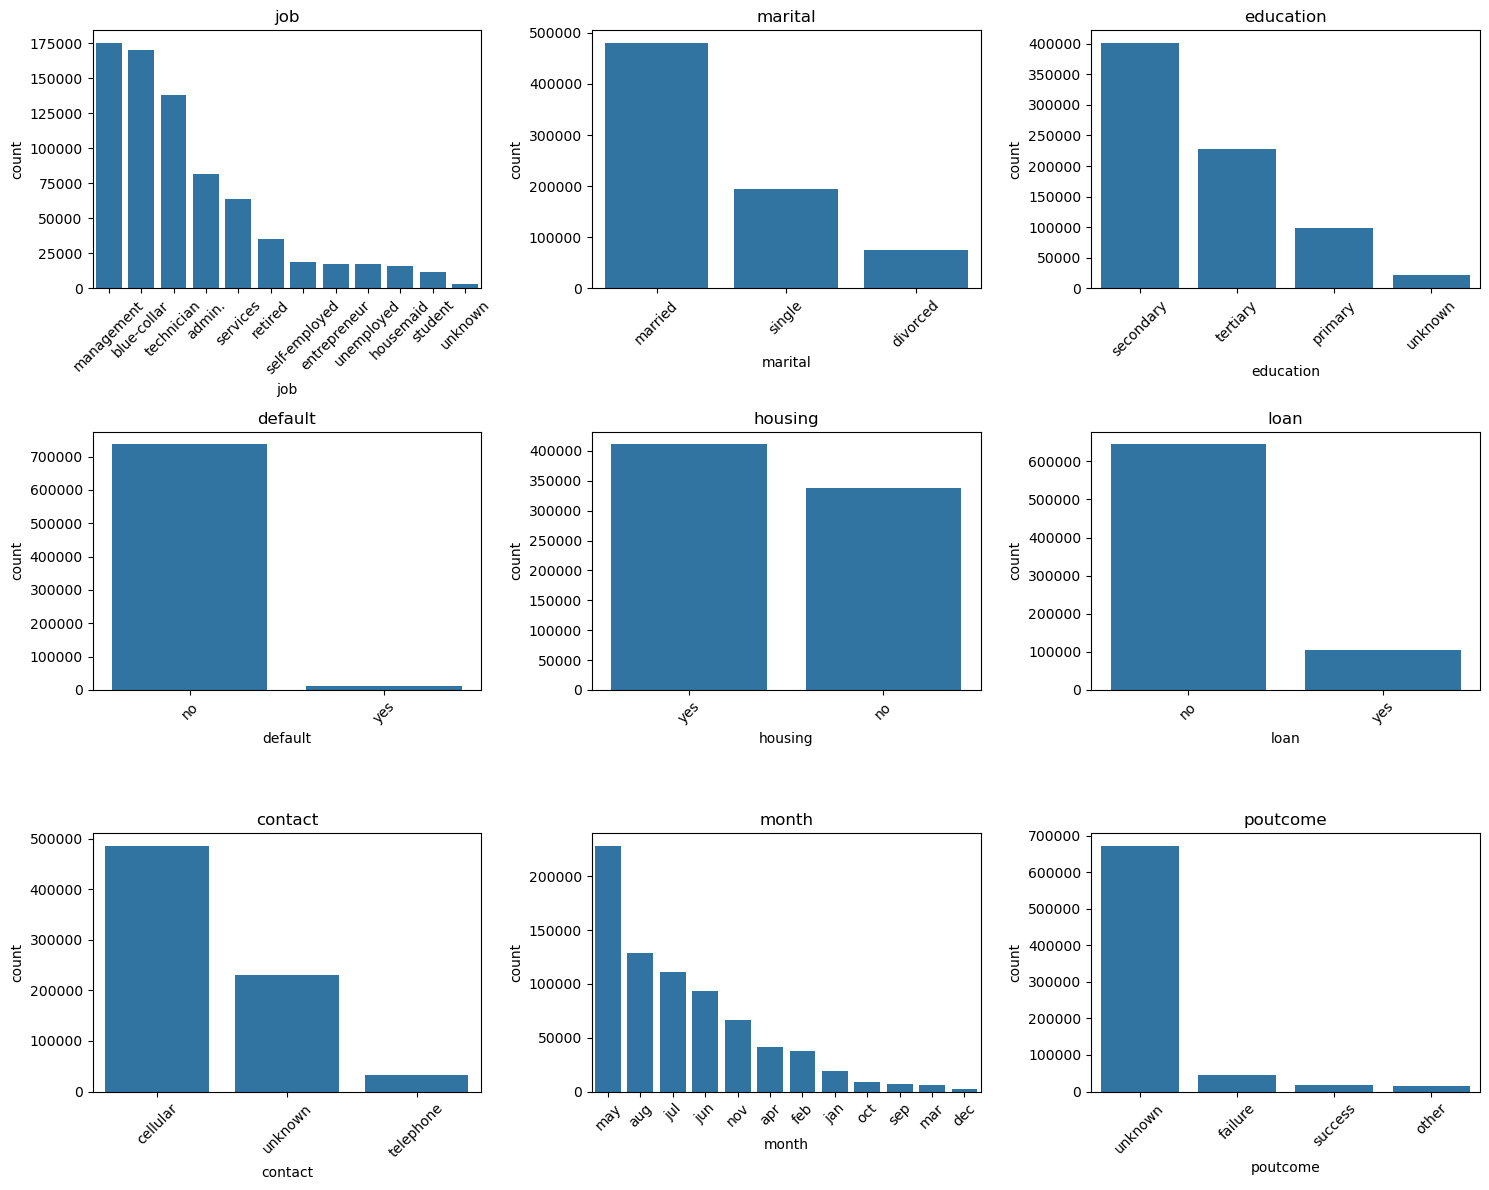

In [40]:
cols = cat_feats
n_cols = 3  
n_rows = math.ceil(len(cols) / n_cols)

fig, axes = plt.subplots(3, 3, figsize=(5*n_cols, 4*n_rows))
axes = axes.flatten()  # flatten for easy indexing

for i, col in enumerate(cols):
    sns.countplot(bank_data, x=col, ax=axes[i], order=bank_data[col].value_counts().index)
    axes[i].set_title(f"{col}")
    axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

A few things stand out:
1. **Contact**: unknowns seems like they're a third or so of the total data.  Would need to revisit these to determine if imputing is possible/advised.  Could also create a binary variable that just notes whether we know the method of contact or not, as that may be informative.
2. **Poutcome**: Each of the 3 non-unknown values are rare (around 5% or less of the total data each); consider removing. However, there may be a strong correlation between success/failure of previous outcomes and current success/failure.  Will need to check for this.
3. **Month**: while some months have a much larger count, does that correlate to success rate?  Additionally, does seasonality play a role?  Winter/Summer?  Given that the order matters, should probably consider converting months to ordinal 1-12 values. 

In [41]:
# Even though it's rare, does poutcome=success correlate highly to success?
bank_data.groupby('poutcome')['y'].mean().sort_values(ascending=False)

poutcome
success    0.764004
other      0.166848
failure    0.132794
unknown    0.101898
Name: y, dtype: float64

Yes, success in poutcome is a good predictor.  Tree models can make use of this without being negatively impacted by the extreme skew; other models may be negatively impacted by this though.

<Axes: xlabel='month'>

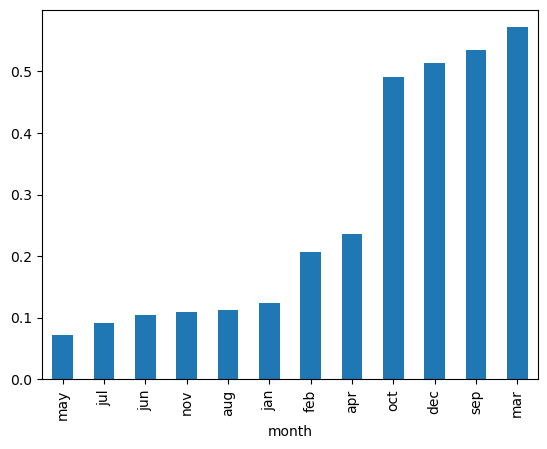

In [57]:
# Success Rate by Month
bank_data.groupby('month')['y'].mean().sort_values().plot(kind='bar')

It would seem the success rate is inversely proportional to total counts for each month.  Let's check this:

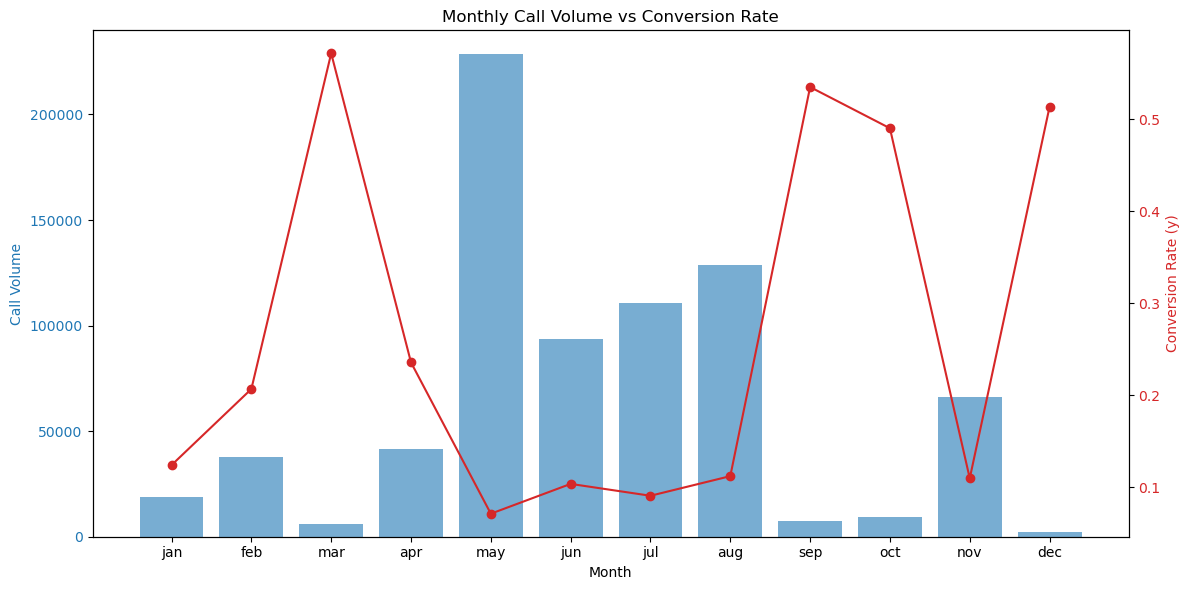

In [58]:
month_counts = bank_data['month'].value_counts()
month_means = bank_data.groupby('month')['y'].mean()

month_order = ['jan','feb','mar','apr','may','jun',
               'jul','aug','sep','oct','nov','dec']
month_counts = month_counts.reindex(month_order)
month_means = month_means.reindex(month_order)

fig, ax1 = plt.subplots(figsize=(12,6))

color = 'tab:blue'
ax1.set_xlabel('Month')
ax1.set_ylabel('Call Volume', color=color)
ax1.bar(month_counts.index, month_counts.values, color=color, alpha=0.6)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Conversion Rate (y)', color=color)
ax2.plot(month_means.index, month_means.values, color=color, marker='o')
ax2.tick_params(axis='y', labelcolor=color)

plt.title('Monthly Call Volume vs Conversion Rate')
plt.tight_layout()
plt.show()

For most months, this is accurate; outside of January and February, and possibly November, success is inversely proportional to total count.  Will need to keep this in mind later; might consider something like a "high conversion rate month" variable or possibly having a conversation rate continuous variable.

### Numerical Values

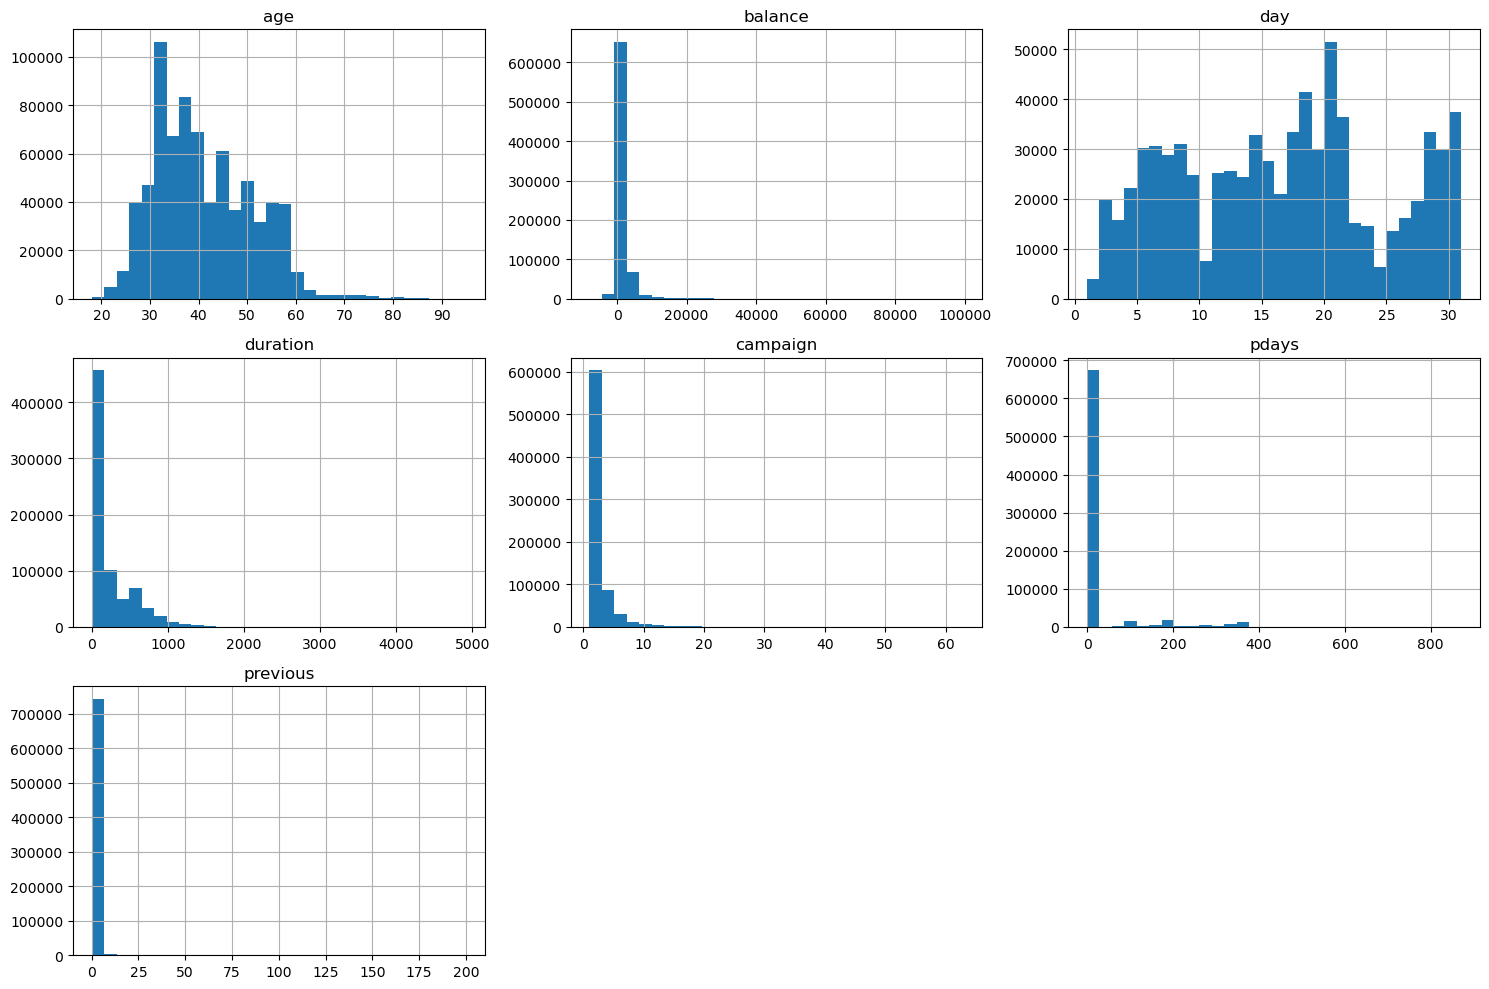

In [61]:
# Plot categorical histograms

num_feats = [x for x in num_feats if x != 'id']
bank_data[num_feats].hist(bins=30, figsize=(15,10))
plt.tight_layout()

There are some troublesome values here, extreme right-skewed variables such as balance, duration, campaign, pdays, and previous. We will have to determine how to handle these values.  If we end up using a tree model of some sort, we can leave these features alone as tree models can handle skewed values in most cases; however, if we don't, we'll have to determine how to handle them (cap values, transform the data - log, power, or Box-Cox, though we'd have to shift the data for BC, regularization, or binning).

Also: duration is something we need to be wary of in a real world scenario.  While the length of a sale-pitch call would probably correlate strongly to whether they were a successful attempt or not, we would never have that information before the call occurred (and since success would be determined by the end of that call, by the time we get the duration value, it's too late for a predictive model to do any good).  For this exercise, I'm not going to toss out the information, but in the real world we'd be careful of leakage like this. 

For pdays, "not contacted" is already encoded as a -1; would have to separate that as a categorical variable (previously contacted vs. not contacted), then treat previous days as a numerical variable only for cases where previous contact was made.  We would also use this "contacted previously vs. not contacted" binary volumn in lieu of keeping the 0s from "previous", as those also represent "not contacted previously" then keep the number of previous contact attempts as a numerical variable.  

I hadn't noticed previously, but the Month and Day variable should reasonably be combined.  While we're not at feature generation yet, this is more checking for bad data than generating new features.  First, check for bad dates (like February 30th, April 31st, etc... (and, if there's a February 29th in the data, perhaps we could try to narrow down which year it is?  Find out days of the week, perhaps)

In [87]:
import pandas as pd

# Month ordering/map
month_order = ['jan','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec']
month_map = {m:i+1 for i,m in enumerate(month_order)} #Assign 1-12 to each month for ordering

df = bank_data.copy()
df['month_num'] = df['month'].map(month_map).astype(int)
df['day_num'] = df['day'].astype(int)

# Pivot values so that each row is the numerical day of month, each column a month
pivot = pd.pivot_table(df, index='day_num', columns='month_num', values='id', aggfunc='count', fill_value=0)

# Rename columns to month names
pivot.columns = [m.capitalize() for m in month_order]

# Display in plain matrix form
display(pivot)

,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
day_num,,,,,,,,,,,,
1,4,64,23,429,3,1602,674,30,682,359,15,5
2,4,8027,705,446,22,9186,795,184,261,66,252,55
3,3,4867,329,592,26,7954,1104,130,427,17,238,140
4,0,7102,133,16,3451,5316,936,4636,325,43,150,162
5,3,6236,566,170,10341,7574,65,5066,48,59,103,14
6,10,3101,82,714,12594,7242,146,5999,220,361,91,13
7,16,16,7,861,13394,43,5977,7405,599,196,17,240
8,44,160,117,1368,12733,302,6960,8061,693,389,135,34
9,4,2684,301,856,7028,6705,5718,121,704,47,375,209


Every month has 31 days; probably a byproduct of the fact that the data was generated and not real.  That also means that trying to determine day of the week likely won't have much meaning either, though we can check on that during feature generation.

### Next Steps

During feature engineering, we'll need to remember the following:

#### Categorical Variables
1. Handling Unknowns: For *job* and *education*, consider keeping the unknowns as a separate category in case they add information (perhaps a certain subset of people choose to not provide that type of info); I wouldn't consider imputing Unknown using Mode for *job* even with the small sample size given the lack of a clearcut leader in total count for any single job category.  Might consider imputing either *education* or *job* if we can find a set of rules to reasonably ascertain the true value for those missing (unknowns).
2. For *contact*, it's too large to feasibly impute using mode or dropping.  We could keep it as is, and just introduce a binary variable ("known_contact_method", TRUE or FALSE).  We could also attempt to impute if we could find a set of rules (or model) that could accurately model the unknowns.
3. For *poutcome*, the unknowns are so large that they cannot be imputed with mode or ignored. Either we remove them or keep them while creating a separate binary indicator for whether the previous outcome was known or not.  I would imagine that a lot of "hasn't been previously contacted" are included as unknowns here, so those cases would be categorized as "never contacted previously" instead.
4. Handling class imbalances: For now, we'll leave the heavy class imbalances alone and attempt to leverage tree models as they aren't as sensitive to imbalance/outliers.  If we need to leverage other models, we'll have to look into binning or transforming the data.

#### Numerical Variables

1. Extremely Skewed Values: balance, duration, campaign, pdays, and previous are all extremely right skewed.  For all except the last two, we'll keep them as is for now given we'll look to use tree models, which can handle the skewed values.
2. pdays and previous: given that a large portion of these variables denote that there was never previous contact, will need to create a separate feature, binary, denoting whether the person was ever previously contacted.  This also needs to be checked against the poutcome categorical variable.  Then, the remaining numeric values in those columns will be considered separately from the large number of "never contacted" values.
3. Day needs to be either be combined with month to create a single value, binned as "beginning, middle, or end of month", or both.